#  Прогнозирование заказов такси

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Случайный лес</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

В наличие есть исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.



Необходимо:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


## Подготовка

In [1]:
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

from catboost import CatBoostRegressor, Pool

import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv',parse_dates=[0], index_col=[0])
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Проверим, монотонные ли данные.

In [4]:
data.index.is_monotonic

C:\Users\Sergey.Polushkin\AppData\Local\Temp\ipykernel_14504\3649924976.py:1: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  data.index.is_monotonic


True

Проверим пустые значения.

In [5]:
data.isna().sum()

num_orders    0
dtype: int64

Приведем индекс к интервалу в 1 час.

In [6]:
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


## Анализ

Попробуем нарисовать времянной ряд и разложим его на тренд, сезонную составляющую и шум.

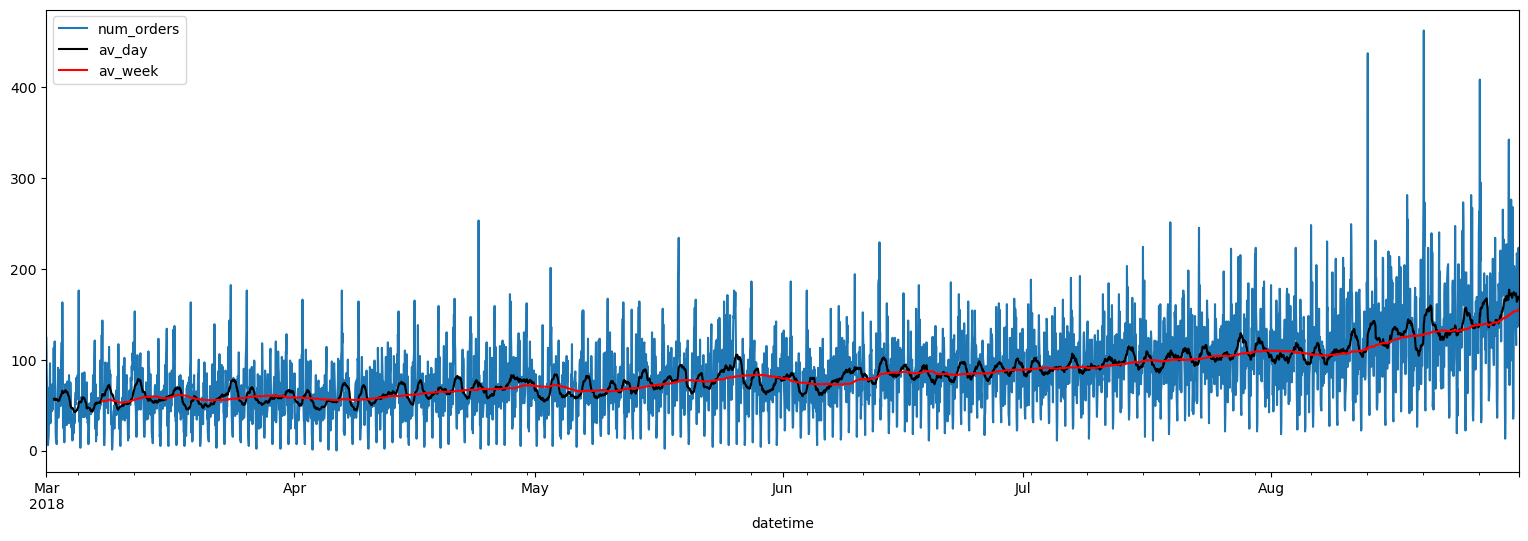

In [8]:
plt.figure(figsize=(19, 6))
data['num_orders'].plot()
data['num_orders'].rolling(24).mean().plot(color='black')
data['num_orders'].rolling(24*7).mean().plot(color='r')
plt.legend(['num_orders','av_day','av_week'])
plt.show()

<AxesSubplot: title={'center': 'trend'}, xlabel='datetime'>

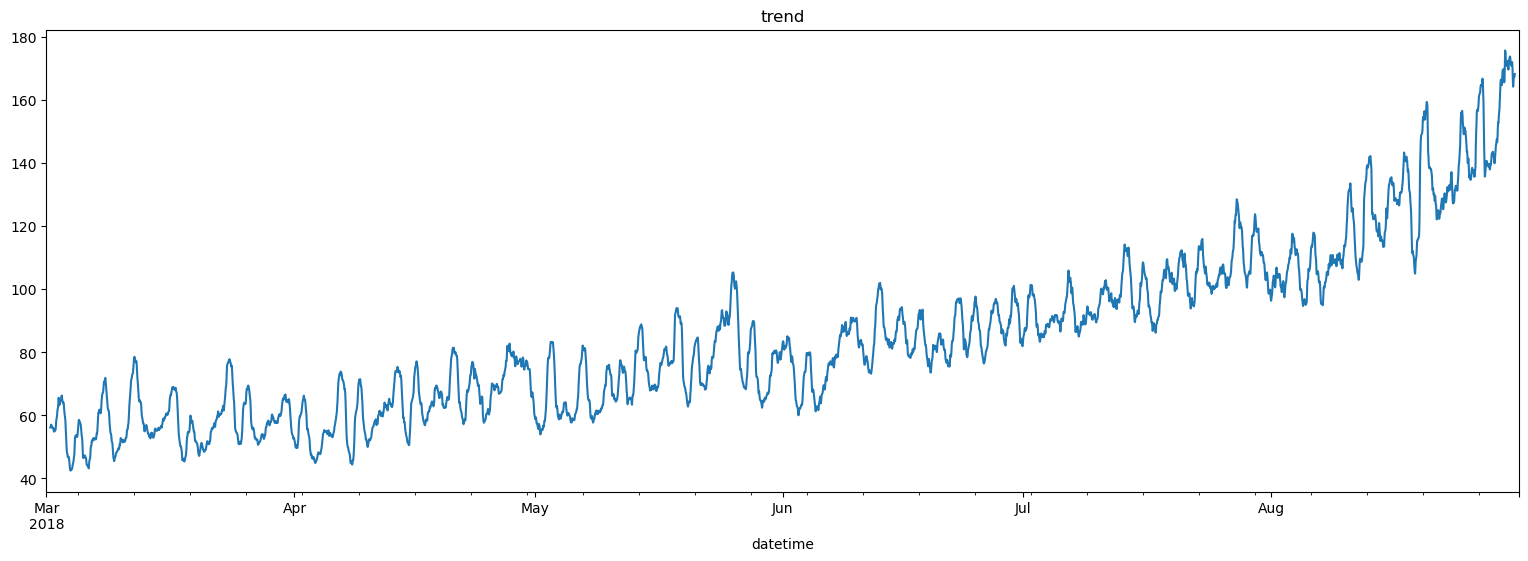

In [9]:
decomposed = seasonal_decompose(data)
plt.figure(figsize=(19, 6))
decomposed.trend.plot(title='trend')

<AxesSubplot: title={'center': 'seasonable'}, xlabel='datetime'>

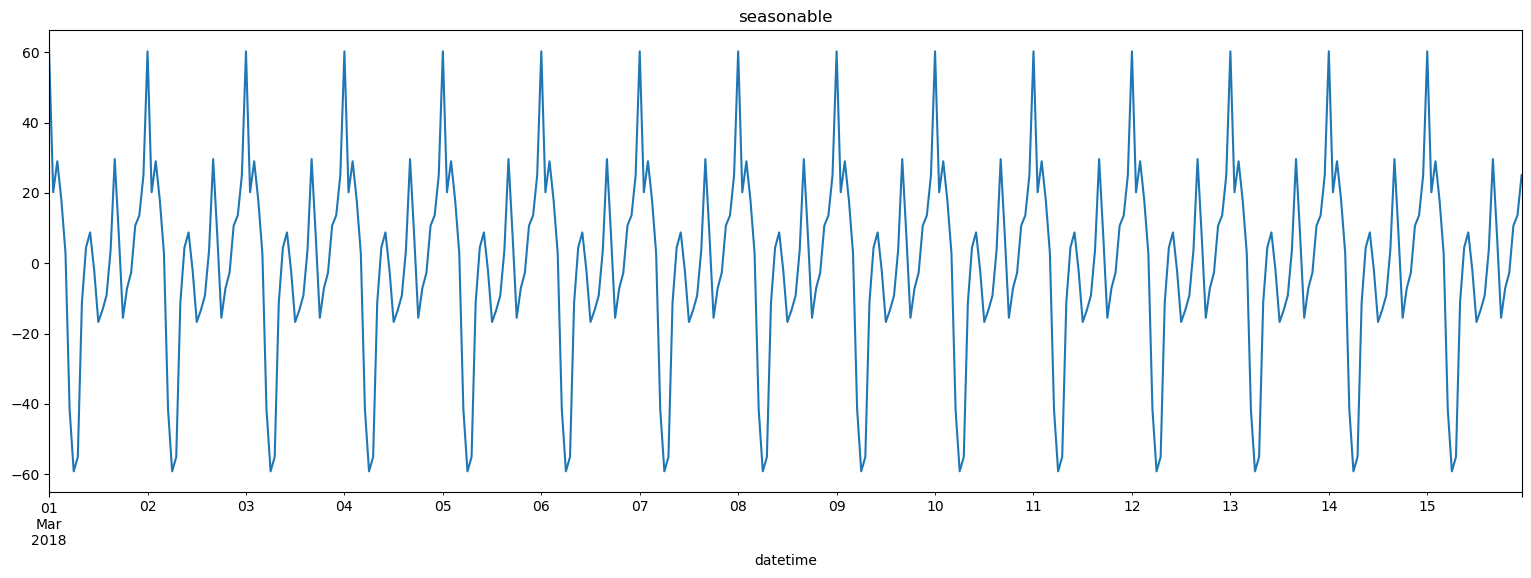

In [10]:
plt.figure(figsize=(19, 6))
decomposed.seasonal['2018-03-01':f'2018-03-15'].plot(title='seasonable')

<AxesSubplot: title={'center': 'residual'}, xlabel='datetime'>

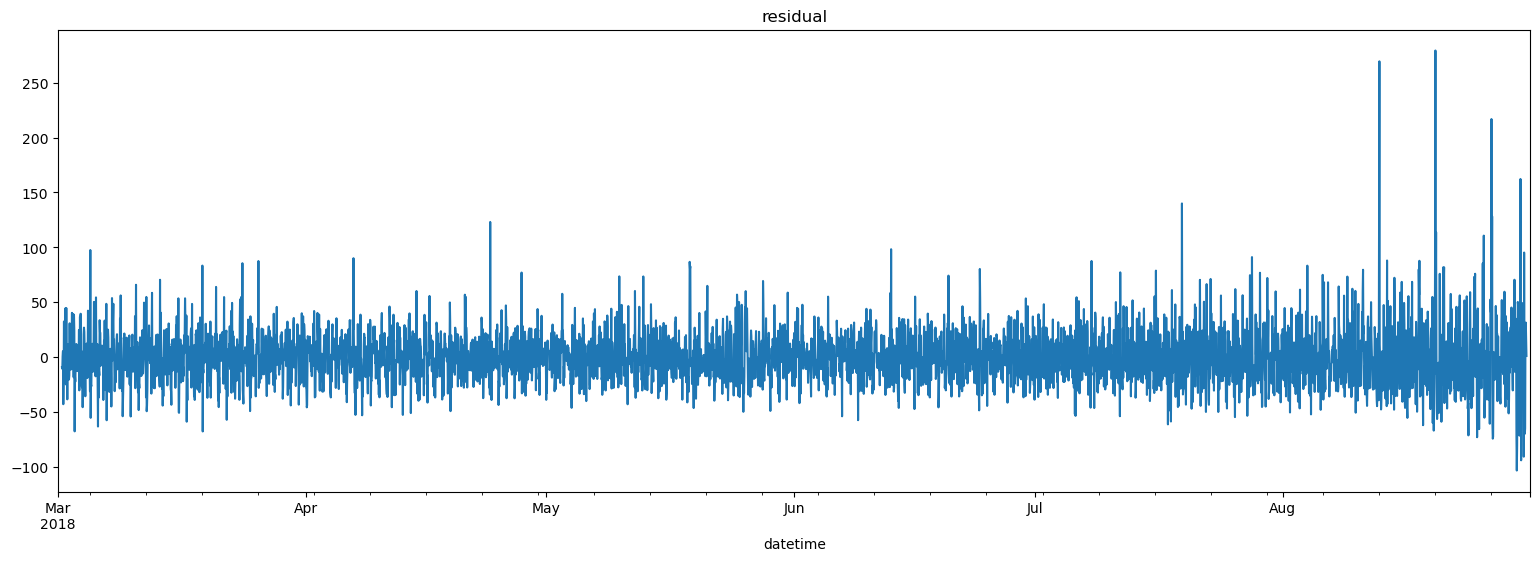

In [11]:
plt.figure(figsize=(19, 6))
decomposed.resid.plot(title='residual')

Посмотрим на разность времянного ряда.

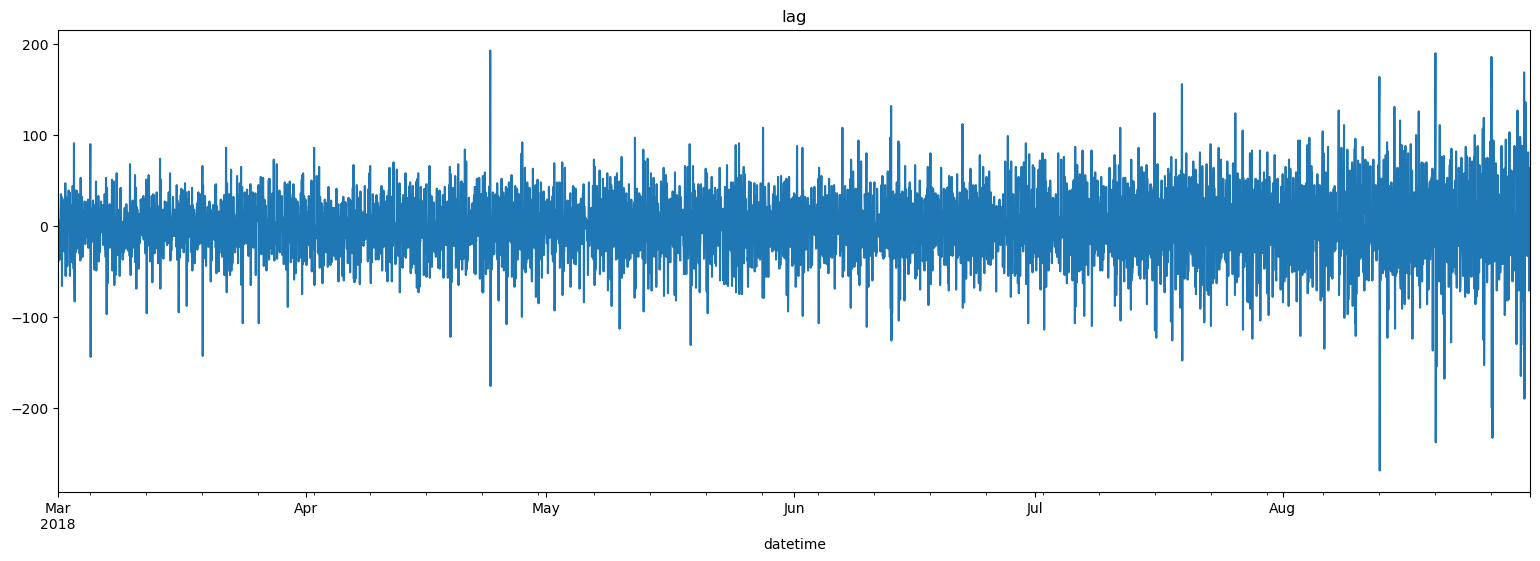

In [12]:
plt.figure(figsize=(19, 6))
(data['num_orders']-data['num_orders'].shift()).plot(title='lag')
plt.show()

### Вывод
- Наблюдается тренд на увеличение заказов с марта по август.

## Обучение

Добавим признаков.

In [13]:
#data['month'] = data.index.month
#data['day'] = data.index.day
data['dayofweek'] = data.index.dayofweek
data['hour'] = data.index.hour
data['rolling_mean'] = data['num_orders'].shift().rolling(24).mean()
for i in range(1, 24):
    data[f'lag_{i}'] = data['num_orders'].shift(i)
data = data.dropna()
data.head()

,num_orders,dayofweek,hour,rolling_mean,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,4,0,56.833333,58.0,113.0,66.0,61.0,45.0,73.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0
2018-03-02 01:00:00,120,4,1,55.416667,90.0,58.0,113.0,66.0,61.0,45.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0
2018-03-02 02:00:00,75,4,2,56.875000,120.0,90.0,58.0,113.0,66.0,61.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0
2018-03-02 03:00:00,64,4,3,57.041667,75.0,120.0,90.0,58.0,113.0,66.0,...,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0
2018-03-02 04:00:00,20,4,4,56.958333,64.0,75.0,120.0,90.0,58.0,113.0,...,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0


### Линейная регрессия

Разделим выборки на обучающую, валидационную и тестовую.

In [14]:
train, test_ = train_test_split(data,shuffle=False, test_size=0.2)
valid, test = train_test_split(test_,shuffle=False, test_size=0.5)
target_train = train['num_orders']
features_train = train.drop(columns=['num_orders'])
target_valid = valid['num_orders']
features_valid = valid.drop(columns=['num_orders'])
target_test = test['num_orders']
features_test = test.drop(columns=['num_orders'])

Оценим линейную регрессию на валидационной выборке.

In [15]:
valid_dict = {}

In [16]:
reg = LinearRegression()
reg.fit(features_train,target_train) 
prediction_valid = reg.predict(features_valid)
valid_dict['LineraRegression'] = [mean_squared_error(target_valid,prediction_valid)**0.5]
valid_dict

{'LineraRegression': [34.377462522806]}

### CatBoost

В CatBoost будем использовать gridsearch, поэтому уберем валидационную выборку и разобъем данные поновому.

In [17]:
train, test = train_test_split(data,shuffle=False, test_size=0.1)
target_train = train['num_orders']
features_train = train.drop(columns=['num_orders'])
target_test = test['num_orders']
features_test = test.drop(columns=['num_orders'])

In [18]:
train_pool = Pool(features_train, target_train)
test_pool = Pool(features_test) 

In [19]:
model = CatBoostRegressor(logging_level='Silent',loss_function='RMSE')

In [20]:
grid = {'learning_rate': [ 0.03, 0.1],
        'depth': [4, 6, 10],
        'iterations':[30, 70, 100],

        }

Чтобы не производить кроссвалидацию зададим индексы явно.

In [21]:
train_indices = np.arange(len(features_train)*0.81,dtype='int32')
validation_indices = np.arange(len(features_train)*0.81+1,len(features_train),dtype='int32')
cv = [(train_indices, validation_indices)]

In [22]:
grid_search_result = model.grid_search(grid,
            train_pool,
            cv=cv,
            shuffle=False,
            verbose=False,
            plot=True
            )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [23]:
valid_dict['CatBoost'] = [min(grid_search_result['cv_results']['test-RMSE-mean'])]
valid_dict['CatBoost']

[33.551242501068934]

In [24]:
grid_search_result['params']

{'depth': 4, 'iterations': 100, 'learning_rate': 0.1}

### Случайный лес

In [25]:
parameters = {'n_estimators':[30,50,70,100], 'max_depth':[3,4,7, 10]}
model = RandomForestRegressor(random_state=12345)
grid_serch_result = GridSearchCV(model, parameters,cv=cv,scoring='neg_root_mean_squared_error')
grid_serch_result.fit(features_train, target_train)
valid_dict['RandomForest'] = [-grid_serch_result.best_score_]
valid_dict['RandomForest']

[33.059271176713274]

In [26]:
grid_serch_result.best_params_

{'max_depth': 10, 'n_estimators': 100}

## Тестирование

In [27]:
pd.DataFrame.from_dict(valid_dict,orient='index',columns=['RMSE']).round(decimals=2).sort_values(by='RMSE')

,RMSE
RandomForest,33.06
CatBoost,33.55
LineraRegression,34.38


Наилучший результат на валидационной выборке показал RandomForest, посмотрим, что он покажет на тестовой выборке.

In [28]:
model = RandomForestRegressor(random_state=12345,n_estimators=100,max_depth=10)
model.fit(features_train,target_train)
prediction_test = model.predict(features_test)
mean_squared_error(target_test,prediction_test)**0.5

44.4326714630762

Результат меньше, чем 48, берем эту модель.

Проверим нашу модель на адекватность. Посчитаем среднее значение последних 10 % значений из обучающей выборки.

In [29]:
prediction_mean = [target_train.iloc[int(len(features_train)*0.9):].mean()]*len(target_test)
mean_squared_error(target_test,prediction_mean)**0.5

65.70376774514975

Наша модель лучше.

Попробуем взять последнее значение.

In [30]:
prediction_mean = [target_train.iloc[-1]]*len(target_test)
mean_squared_error(target_test,prediction_mean)**0.5

68.50894102232205

И тут наша модель лучше.

Ради интереса посчитаем, как покажут себя остальные модели на тестовой выборке.

In [31]:
model = LinearRegression()
model.fit(features_train,target_train) 
prediction_test = model.predict(features_test)
mean_squared_error(target_test,prediction_test)**0.5

45.22409490531756

Линейная регрессия вообще тест не прошла.

In [32]:
model = CatBoostRegressor(iterations=100, 
                          depth=4, 
                          learning_rate=0.1, 
                          loss_function='RMSE',
                          logging_level='Silent')

model.fit(train_pool)
prediction_test = model.predict(test_pool)
mean_squared_error(target_test,prediction_test)**0.5

48.75479503040083

И CatBoost не прошел.

### Вывод
 - Наилучшую предсказательную способность показал Случайный Лес. Эта модель единственная показала необходимый результат на тестовой выборке. Кроме того она показала предсказательную способность лучше, чем прогноз средним или последним значением. Значит именно эту модель мы и порекомендуем заказчику.